In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from Model import GaussianMixtureModel
import numpy as np
from Cluster_Metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split

$$ P(X|\lambda) = \sum_{k=1}^{K} \pi_k \mathcal{N}(X|\mu_k, \Sigma_k) $$

X is the data, λ represents the parameters of the model, π_k are the mixture weights, and $\mathcal{N}(X|\mu_k, \Sigma_k)$ is the Gaussian distribution for component k.

In [2]:
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    v, w = np.linalg.eigh(cov)
    v = np.maximum(v, 0)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.degrees(np.arctan2(u[1], u[0]))
    ell = Ellipse(xy=pos, width=v[0]*nstd, height=v[1]*nstd, angle=angle, **kwargs)
    ell.set_facecolor('none')
    ax.add_patch(ell)

# Q1

In [3]:
def load_data(dataset_path):
    data = pd.read_csv("Datasets/"+ dataset_path)
    y_true = data['class']
    data = data.drop('class', axis=1)
    return data, y_true

In [4]:
def normalization(data):
    demean = data - data.mean()
    unit_variance = demean / data.std()
    return unit_variance

# Q2-5

In [5]:
def GMM(X, n_components):
    gmm = GaussianMixtureModel(n_components)
    gmm.fit(X)
    return gmm

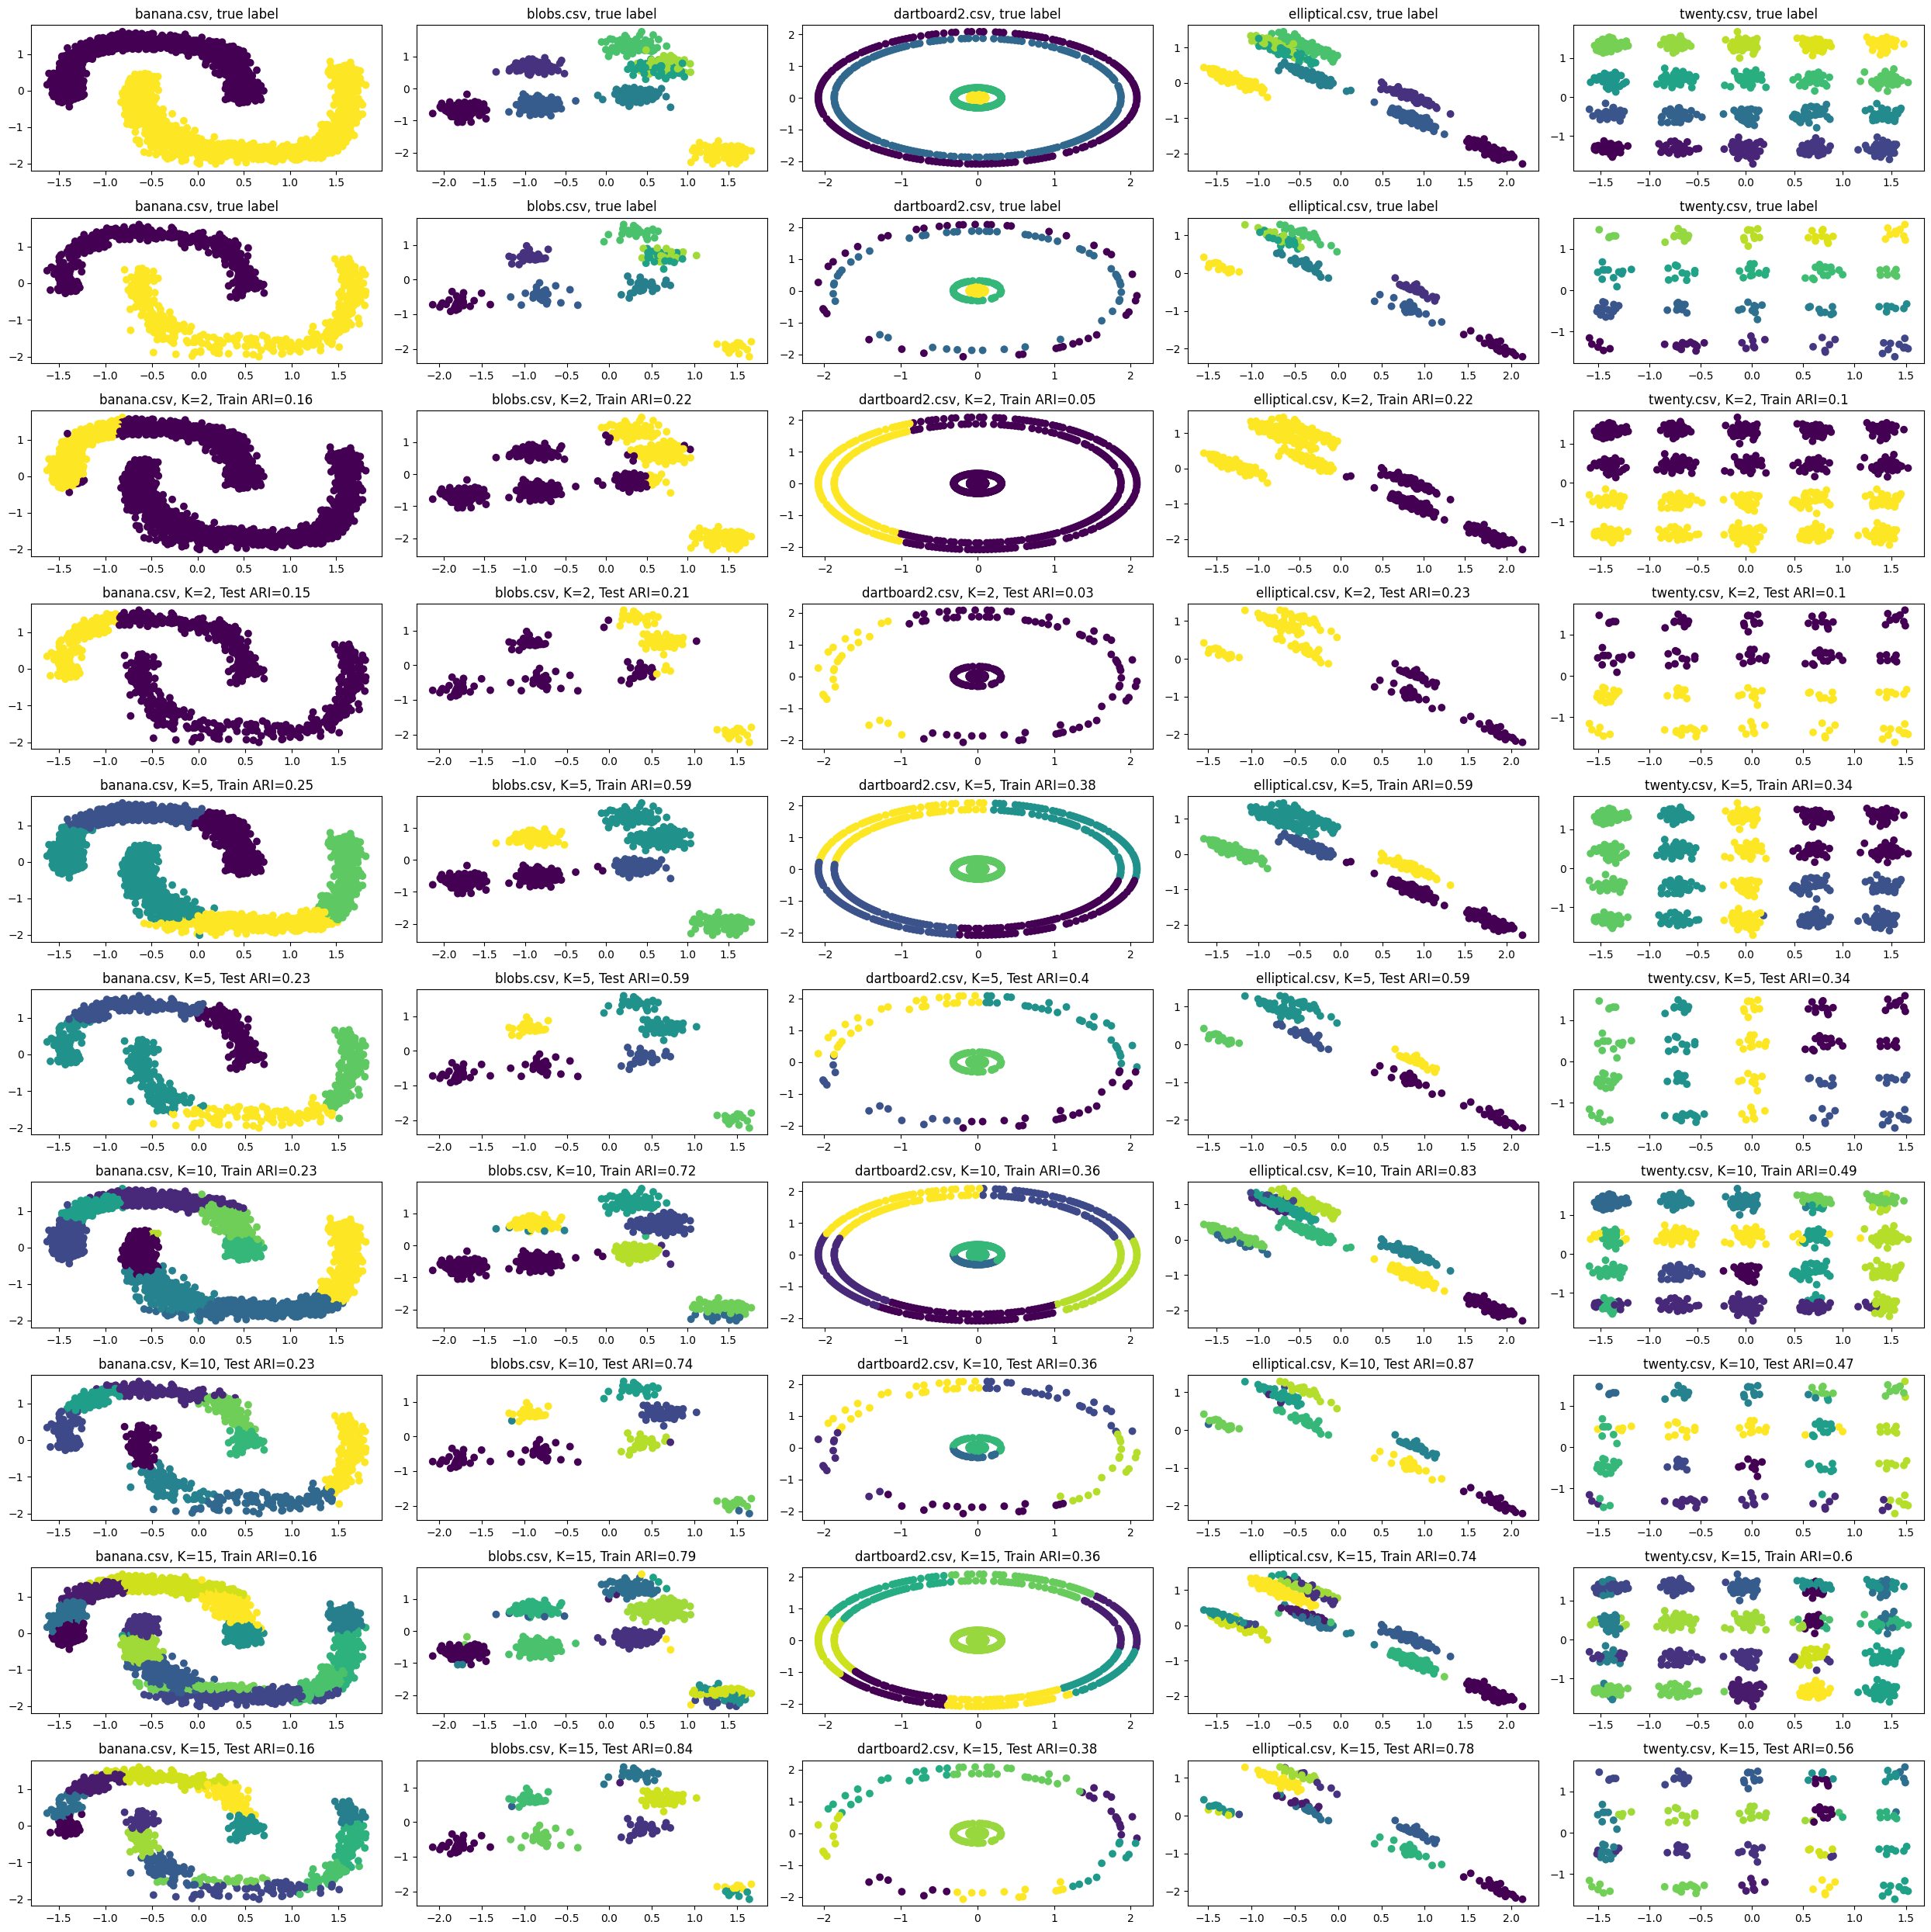

In [6]:
datasets_path = ['banana.csv','blobs.csv','dartboard2.csv','elliptical.csv','twenty.csv']
datasets = []
metrics = []
for dataset_path in datasets_path:
    data, labels = load_data(dataset_path)
    metrics.append((data.mean(),data.std()))
    data = normalization(data)
    datasets.append((data,labels))
    
k_values = [2, 5, 10, 15]

fig, axs = plt.subplots(len(k_values) * 2 + 2, len(datasets), figsize=(25, 25))

for j, (dataset, y_true) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(dataset.values, y_true, test_size=0.2, random_state=42)
    axs[0, j].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=50, edgecolors='k', linewidth=0)
    axs[0, j].set_title(f'{datasets_path[j]}, true label')
    axs[1, j].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', s=50, edgecolors='k', linewidth=0)
    axs[1, j].set_title(f'{datasets_path[j]}, true label')
    
for i, k in enumerate(k_values):
    for j, (dataset, y_true) in enumerate(datasets):
        X_train, X_test, y_train, y_test = train_test_split(dataset.values, y_true, test_size=0.2, random_state=42)

        # Plot training data
        gmm = GMM(X_train, k)
        y_pred_train = gmm.predict(X_train)
        axs[2 * i + 2, j].scatter(X_train[:, 0], X_train[:, 1], c=y_pred_train, cmap='viridis', s=50, edgecolors='k', linewidth=0)
        ari_train = adjusted_rand_score(y_train.values, y_pred_train)
        axs[2 * i + 2, j].set_title(f'{datasets_path[j]}, K={k}, Train ARI={np.round(ari_train, 2)}')

        # Plot testing data
        y_pred_test = gmm.predict(X_test)
        axs[2 * i + 3, j].scatter(X_test[:, 0], X_test[:, 1], c=y_pred_test, cmap='viridis', s=50, edgecolors='k', linewidth=0)
        ari_test = adjusted_rand_score(y_test.values, y_pred_test)
        axs[2 * i + 3, j].set_title(f'{datasets_path[j]}, K={k}, Test ARI={np.round(ari_test, 2)}')

plt.tight_layout()
plt.show()

# Q6

Both metrics balance the goodness of fit and the complexity of the model.

1. **Bayesian Information Criterion (BIC):**
   - **Definition:** BIC is a criterion for model selection among a finite set of models. It is based on the likelihood function and the number of parameters in the model.
   - **Formula:** $$ BIC = -2 \times \text{Log-Likelihood} + 0.5 \times k \times \ln(n) $$
     - $ \text{Log-Likelihood} $: The logarithm of the maximized likelihood of the model given the data.
     -  k : The number of parameters in the model.
     -  n : The number of data points.
   - **Selection Rule:** Choose the model with the lowest BIC value.

2. **Akaike Information Criterion (AIC):**
   - **Definition:** AIC is another information criterion used for model selection. Like BIC, it penalizes models for the number of parameters.
   - **Formula:** $$ AIC = -2 \times \text{Log-Likelihood} + 2 \times k $$
     - $ \text{Log-Likelihood} $: The logarithm of the maximized likelihood of the model given the data.
     -  k : The number of parameters in the model.
   - **Selection Rule:** Choose the model with the lowest AIC value.

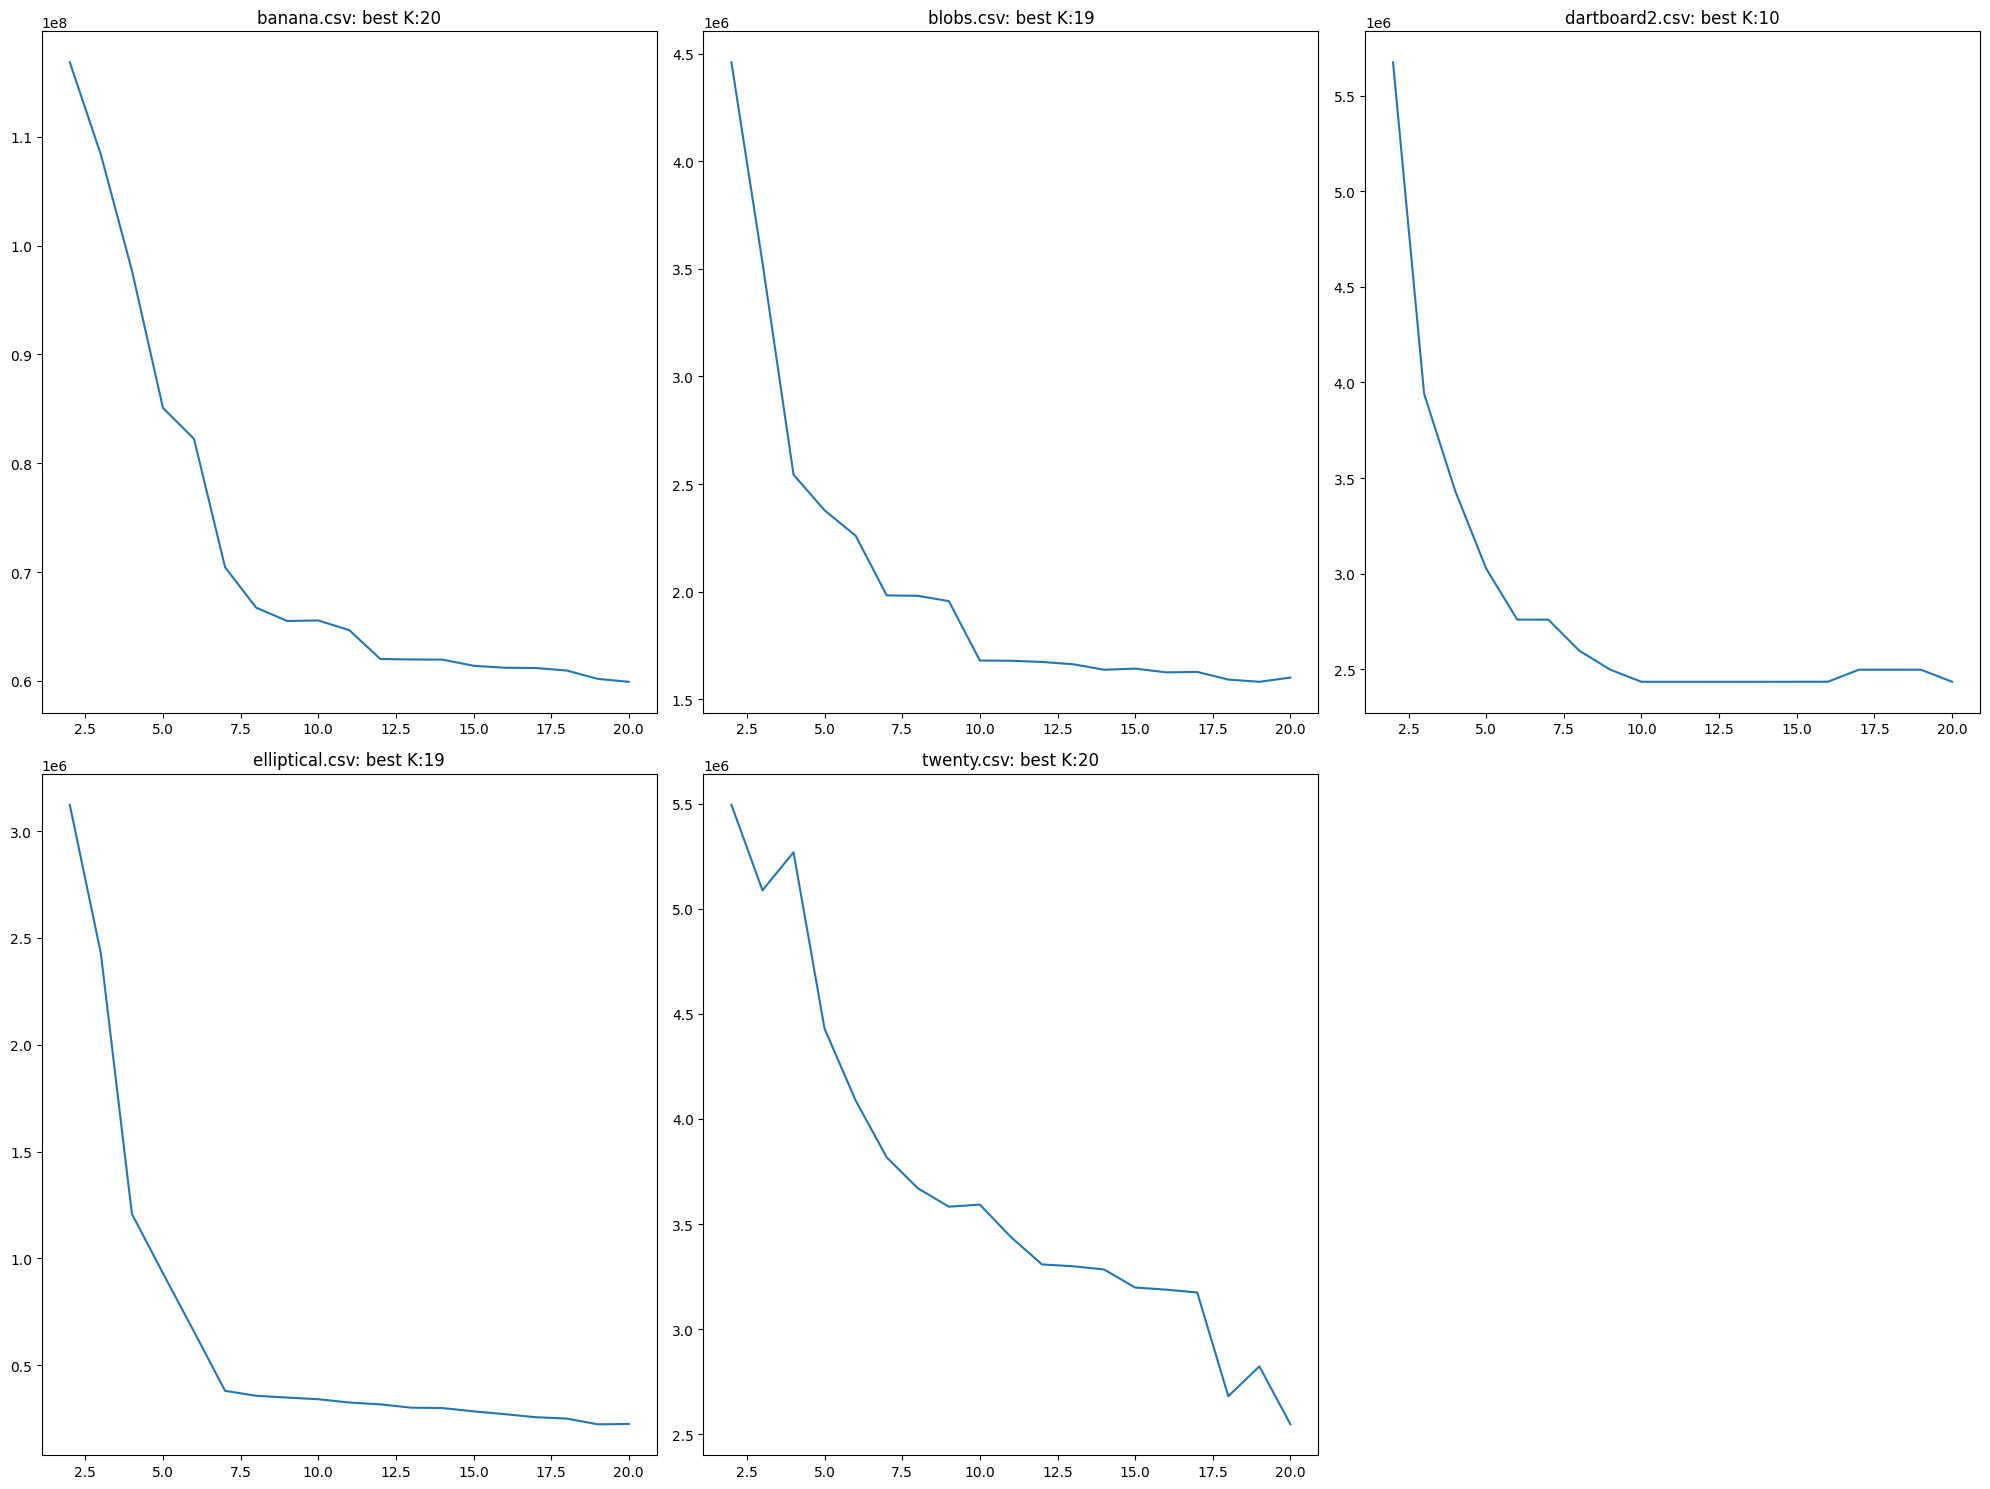

In [7]:
num_datasets = len(datasets)
num_rows = int(np.ceil(num_datasets / 3))  
bic_best_k = []
fig, axs = plt.subplots(num_rows, 3, figsize=(20, 15))  
for i, (dataset, y_true) in enumerate(datasets):
    bic_values = []
    X = dataset.values
    for k in range(2, 21):  
        gmm = GMM(X, k)
        bic_values.append(gmm.bic(X))
      
    row_idx = i // 3
    col_idx = i % 3
    axs[row_idx, col_idx].plot(list(range(2, 21)), bic_values)
    best_k = np.argmin(bic_values)+2
    axs[row_idx, col_idx].set_title(f'{datasets_path[i]}: best K:{best_k}')
    bic_best_k.append(best_k)

for j in range(i + 1, num_rows * 3):
    axs[j // 3, j % 3].axis('off')

plt.tight_layout()
plt.show()

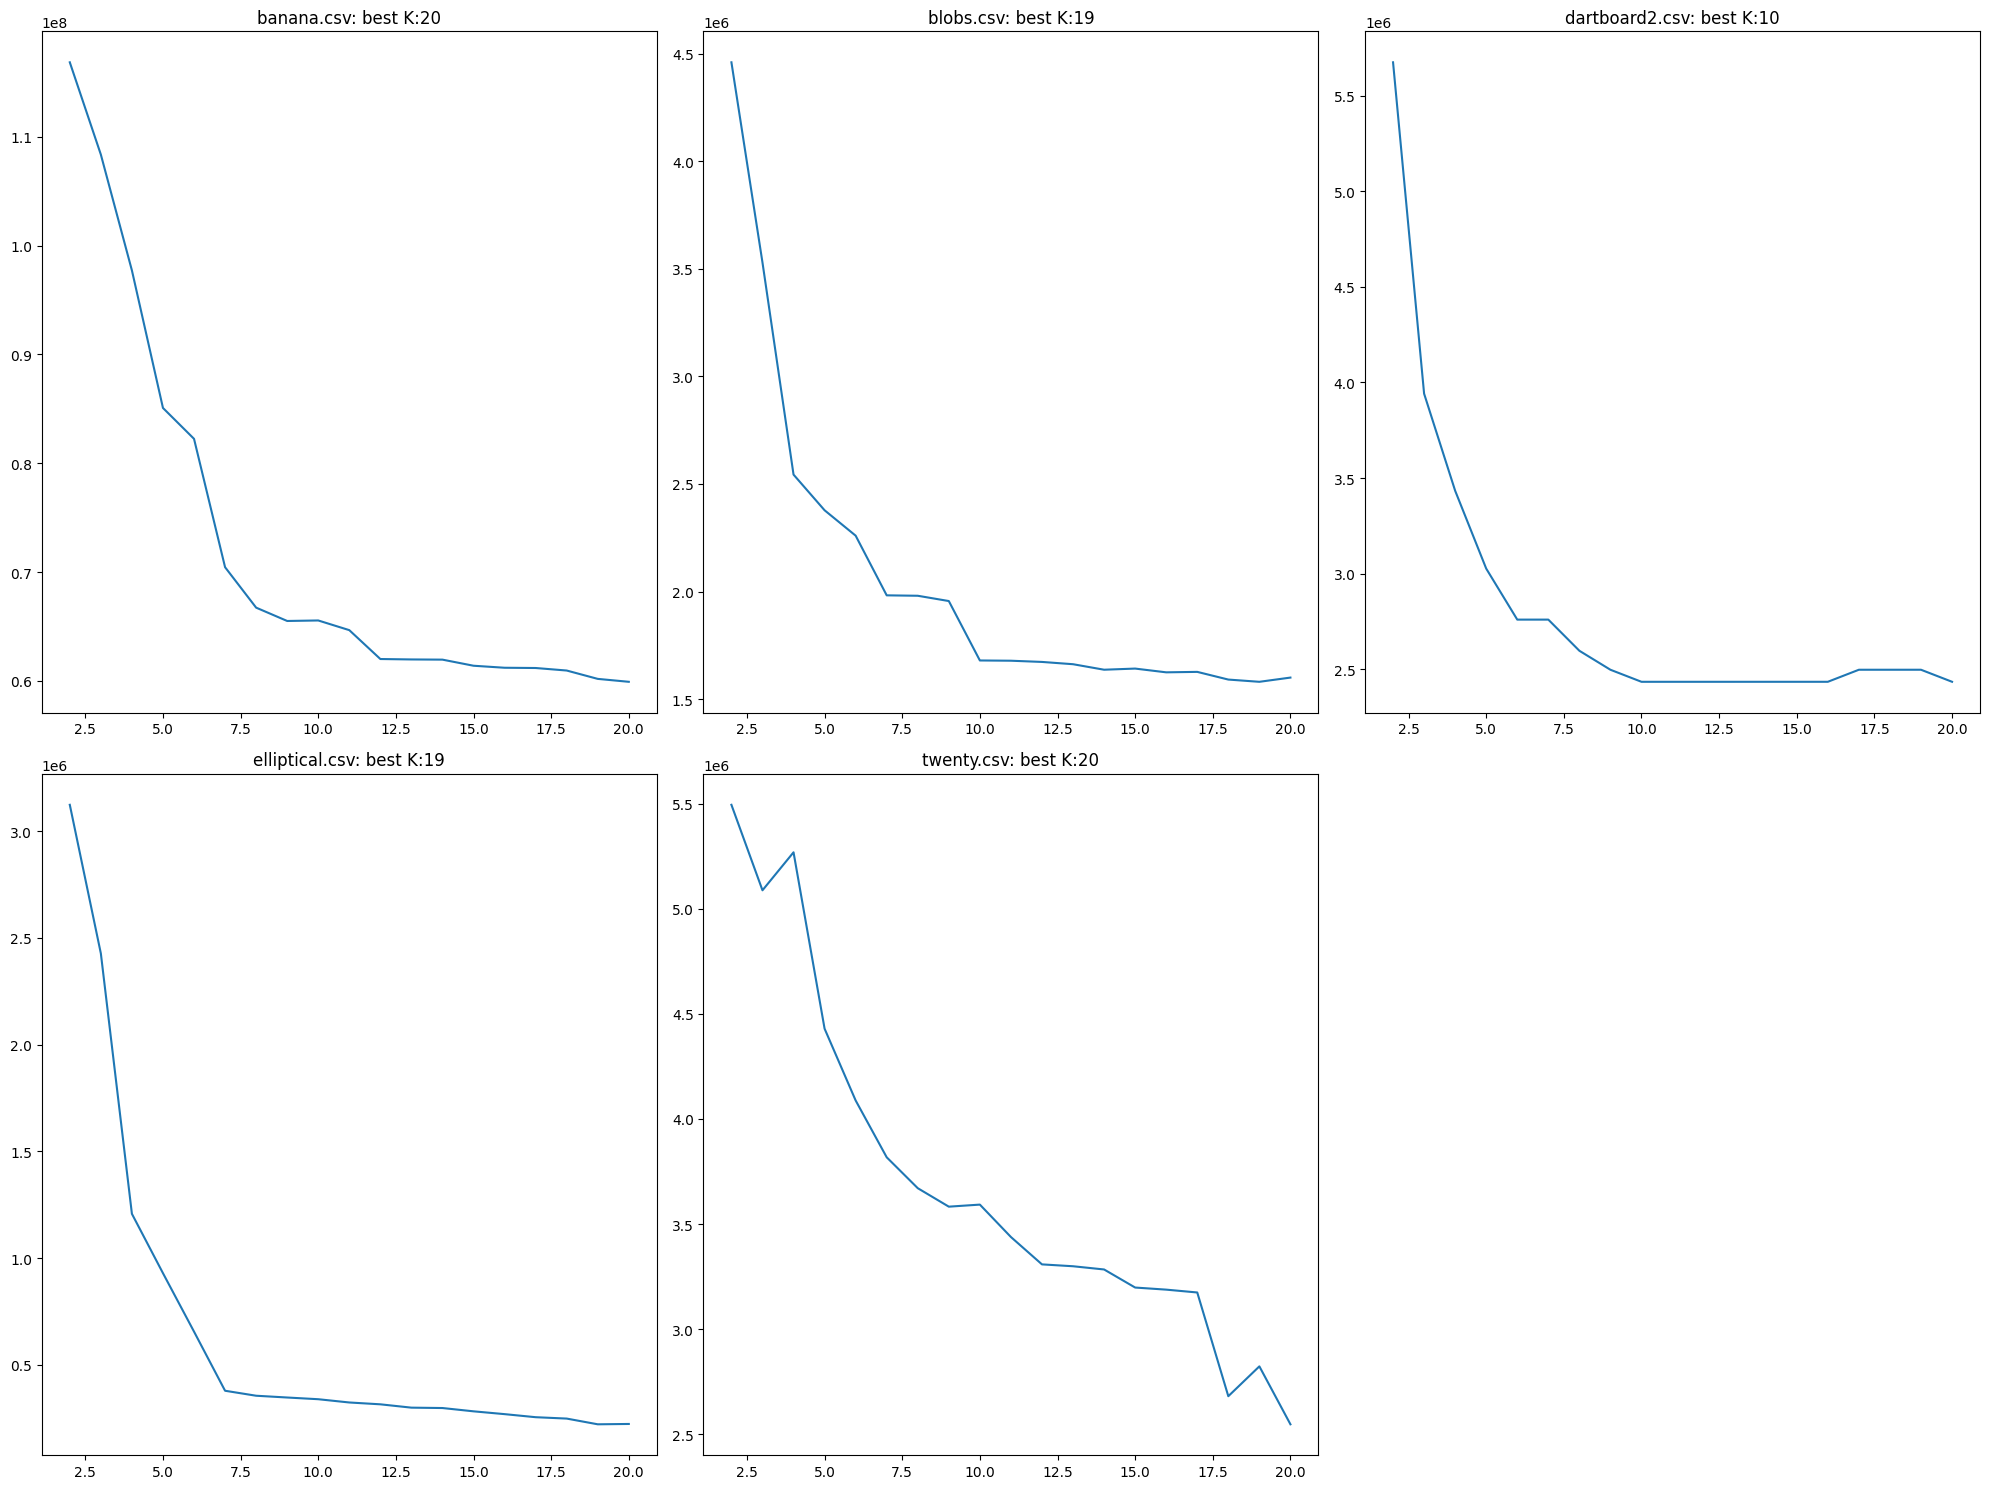

In [8]:
num_datasets = len(datasets)
num_rows = int(np.ceil(num_datasets / 3))  
aic_best_k = []
fig, axs = plt.subplots(num_rows, 3, figsize=(20, 15))  
for i, (dataset, y_true) in enumerate(datasets):
    aic_values = []
    X = dataset.values
    for k in range(2, 21):  
        gmm = GMM(X, k)
        aic_values.append(gmm.aic(X))
      
    row_idx = i // 3
    col_idx = i % 3
    axs[row_idx, col_idx].plot(list(range(2, 21)), aic_values)
    best_k = np.argmin(aic_values) + 2
    axs[row_idx, col_idx].set_title(f'{datasets_path[i]}: best K:{best_k}')
    aic_best_k.append(best_k)

for j in range(i + 1, num_rows * 3):
    axs[j // 3, j % 3].axis('off')

plt.tight_layout()
plt.show()

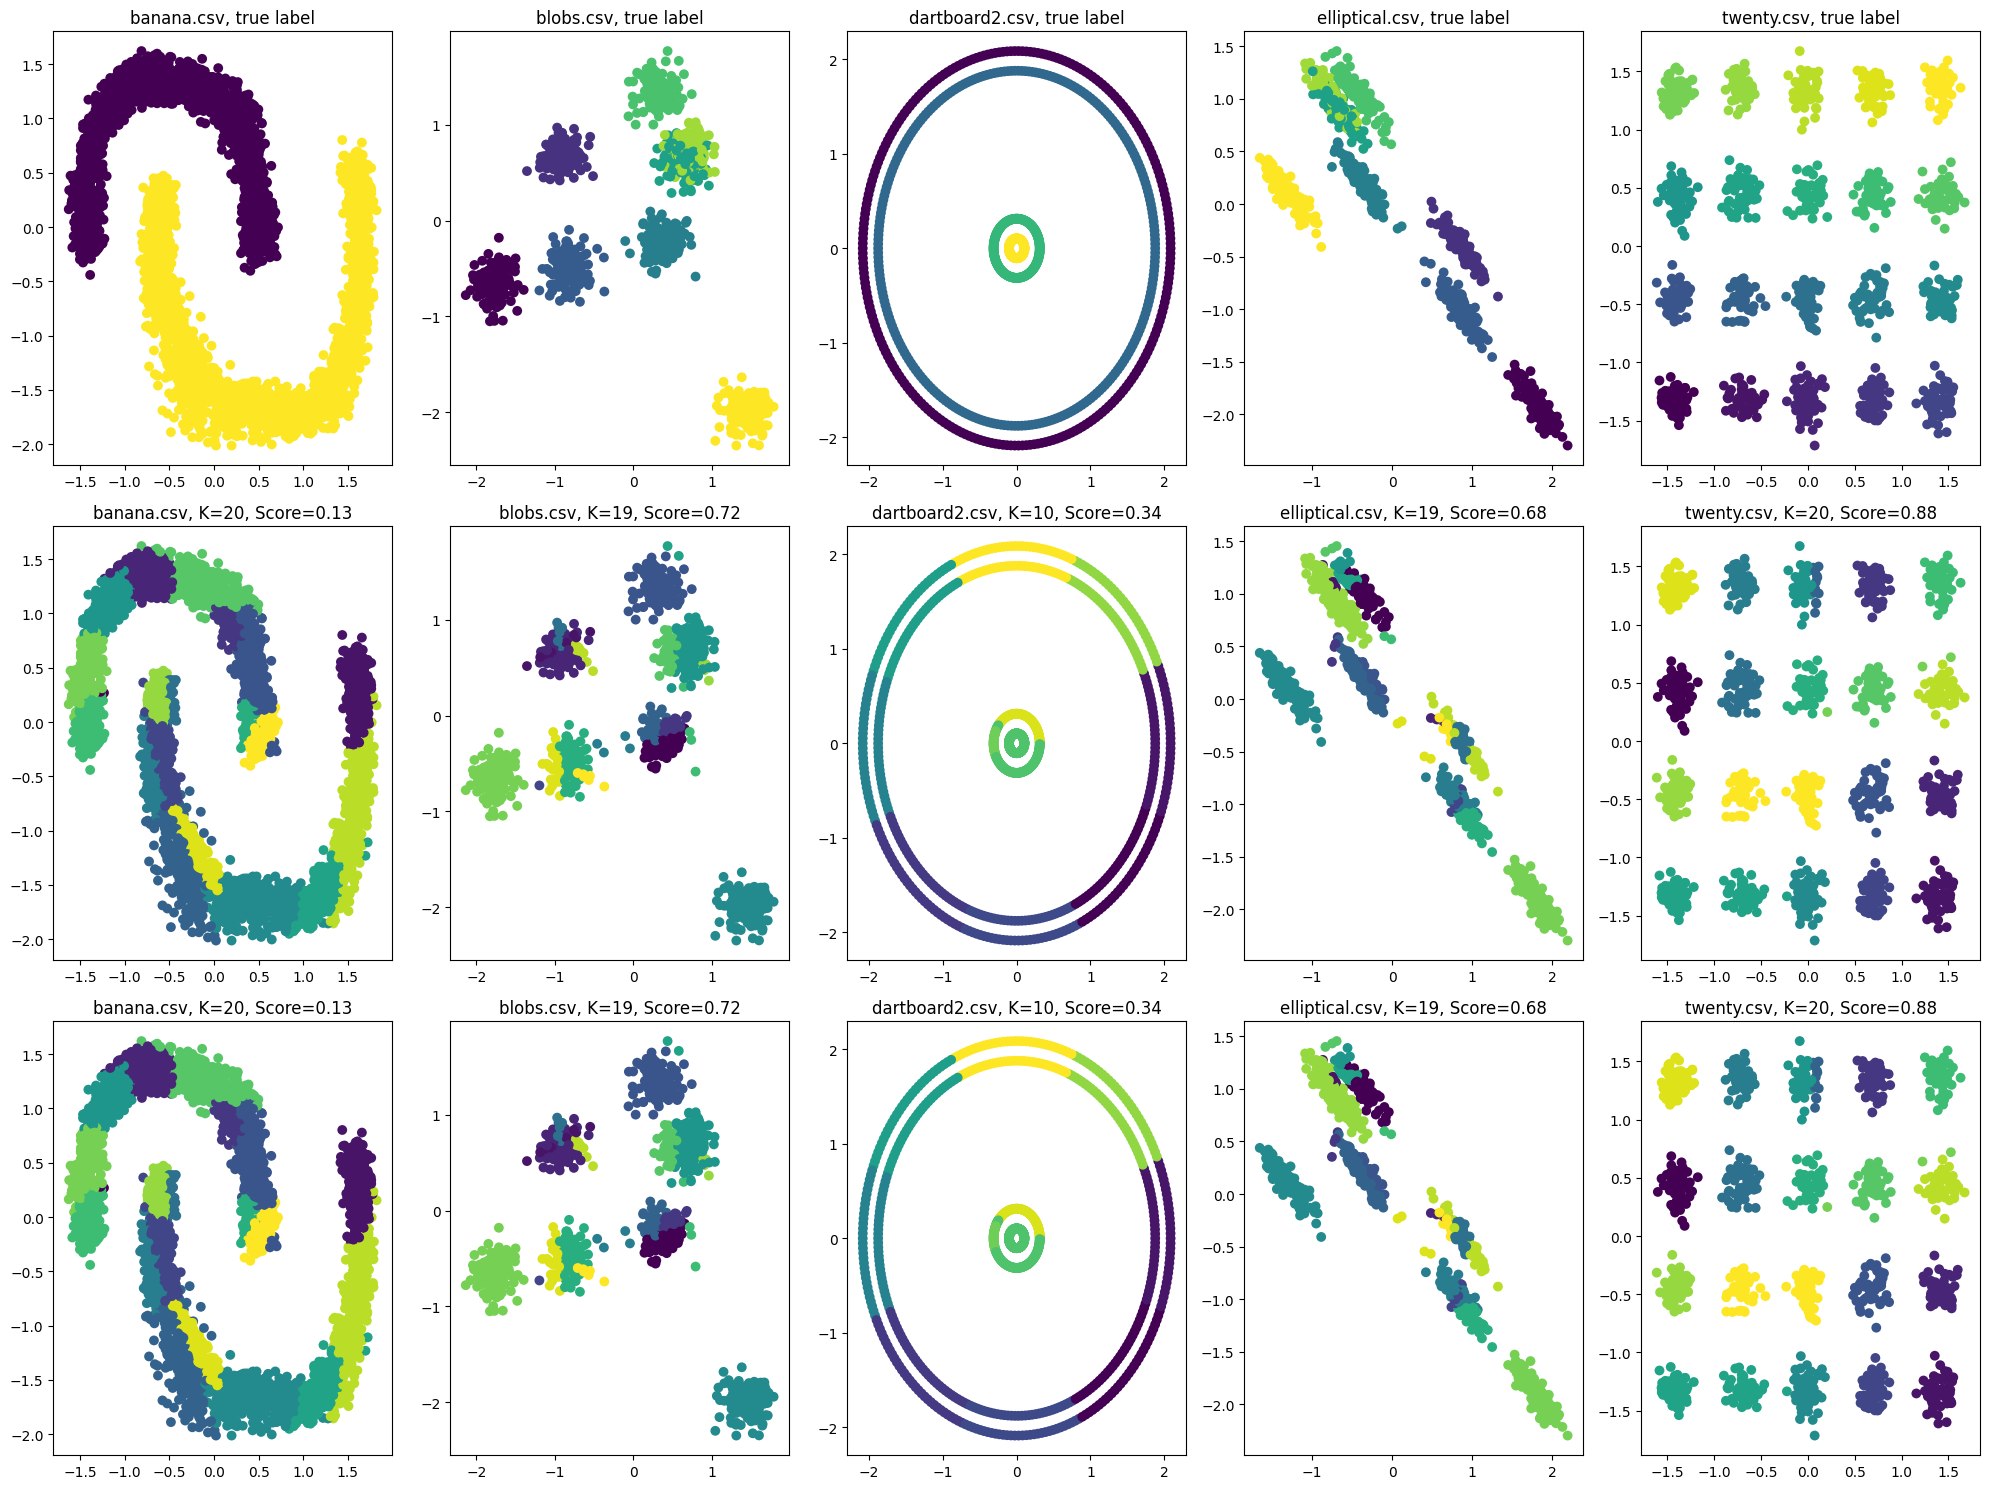

In [9]:
fig, axs = plt.subplots(3, len(datasets), figsize=(20, 15))  
for j, (dataset, labels) in enumerate(datasets):
    axs[0, j].scatter(dataset.iloc[:, 0], dataset.iloc[:, 1], c=labels, cmap='viridis', s=50, edgecolors='k', linewidth=0)
    axs[0, j].set_title(f'{datasets_path[j]}, true label')
    
for i , best_k in enumerate([bic_best_k, aic_best_k]):
    for j, (dataset, y_true) in enumerate(datasets):
        X = dataset.values
        gmm = GMM(X, k)
        y_pred = gmm.predict(X)
        axs[i+1, j].scatter(X[:, 0], X[:, 1], c=y_pred, cmap='viridis', s=50, edgecolors='k', linewidth=0)
#         plot_kmeans_clusters(dataset, kmeans.centroids,best_k[j] y_pred, ax=axs[i, j])
        ari = adjusted_rand_score(np.array(y_true), np.array(y_pred))
        axs[i+1, j].set_title(f'{datasets_path[j]}, K={best_k[j]}, Score={round(ari, 2)}')

plt.tight_layout()
plt.show()

# Q8

Both datasets, the dartboard, and banana datasets, exhibit poor performance with KMeans and GMM due to their special shapes. However, on other datasets, GMM outperforms KMeans, thanks to its consideration of covariance alongside means.

In [14]:
from tabulate import tabulate

methods = ["Kmeans"]*5
best_ks = [13,20,20,20,19]
ari = [0.16,0.56,0.17,0.55,0.83]
data = list(zip(methods,datasets_path, best_ks, ari))
table = tabulate(data, headers=['Method','Dataset', 'Best K', 'ARI'], tablefmt='grid')
print(table)
methods = ["GMM"]*5
best_ks = [20,19,10,19,20]
ari = [0.13,0.72,0.34,0.68,0.88]
data = list(zip(methods,datasets_path, best_ks, ari))
table = tabulate(data, headers=['Method','Dataset', 'Best K', 'ARI'], tablefmt='grid')
print(table)

+----------+----------------+----------+-------+
| Method   | Dataset        |   Best K |   ARI |
+==========+================+==========+=======+
| Kmeans   | banana.csv     |       13 |  0.16 |
+----------+----------------+----------+-------+
| Kmeans   | blobs.csv      |       20 |  0.56 |
+----------+----------------+----------+-------+
| Kmeans   | dartboard2.csv |       20 |  0.17 |
+----------+----------------+----------+-------+
| Kmeans   | elliptical.csv |       20 |  0.55 |
+----------+----------------+----------+-------+
| Kmeans   | twenty.csv     |       19 |  0.83 |
+----------+----------------+----------+-------+
+----------+----------------+----------+-------+
| Method   | Dataset        |   Best K |   ARI |
+==========+================+==========+=======+
| GMM      | banana.csv     |       20 |  0.13 |
+----------+----------------+----------+-------+
| GMM      | blobs.csv      |       19 |  0.72 |
+----------+----------------+----------+-------+
| GMM      | dartboa